# Schrödinger with double well and time-dependent laser potential

*&#169; Copyright 2019-2022 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, abs, real, imag, pi
from torch.linalg import matrix_exp

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The Schrödinger equation

The linear time-dependent Schrödinger equation in 1D with periodic boundaries over a domain $[-L,L]$ can be written as

$$ i \partial_t \psi(x,t) = \mathrm{H}(t) \psi(x,t), \qquad x \in [-L,L] $$

where $\mathrm{H}$(t) is an explicitly time-dependent Hamiltonian operator

$$ \mathrm{H} = -\partial_x^2 + V(x,t) $$

and $V(x,t)$ is a time-dependent potential function. In this example we will assume

$$ V(x,t) = V_0(x) + e(t)x $$

where $V_0(x)$ is a time-independent potential, and $e(t) x$ is a laser potential under the dipole approximation. $e(t)$ describes the time-profile of the laser pulse.

### Magnus expansion $O(h^2)$

An approximate solution of the Schrödinger is given by the second order Magnus expansion,

$$ u_{n+1} = \exp\left(i h \partial_x^2 - i h V_0(x) - i r_n x\right) u_n $$

where

$$ r_n = \int_0^h e(t_n+s) ds $$

and $u_0 = \psi(0)$. It can be proven that $u_N = \psi(t_N) + O(h^2)$ as $N \rightarrow \infty, h \rightarrow 0$ with $T = Nh$ fixed.

We may further approximate 

$$ r_n \approx \frac{h}{2}(e(t_n)+e(t_{n+1})) $$

or

$$ r_n \approx e\left(t_n+\frac{h}{2}\right) $$

without losing the order of accuracy.

### Approximating the exponential

We spatially the operator $i h \partial_x^2 - i h V_0(x) - i r_n x$, and approximate it by $i h \mathrm{D}_2 -i h \texttt{diag}(V_0) - i r_n \texttt{diag}(x)$, so that we need to compute

$$ u_{n+1} = \exp\left(i h \mathrm{D}_2 -i h\, \texttt{diag}(V_0) - i r_n \texttt{diag}(x)\right) u_n $$

We have two options at this stage: compute the matrix exponential exactly using $\texttt{expm}$, or split the exponential using Strang splitting,

$$ u_{n+1} = \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) - i \frac{r_n}{2} \texttt{diag}(x)\right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) - i \frac{r_n}{2} \texttt{diag}(x)\right) u_n $$


# Numerical example

We consider solving the Schrödinger equation over the spatial domain $x\in [-10,10]$ and  temporal domain $t\in [0,1]$ with a double well potential,

$$ V_0(x) = x^4 - 10 x^2 $$

and a sinusoidal time-dependent laser profile,

$$ e(t) = -100 \sin(5 \pi t) $$

with a Gaussian initial condition

$$ \psi(0) = c \exp\left(-\frac{(x-x_0)^2}{2\sigma^2}\right) $$

centred at $x_0=-2$ and with standard deviation $\sigma = 0.5$, and where $c$ is chosen to normalise $\psi(0)$.

We will use $N=250$ spatial grid points and $M=100$ temporal grid points.

### Spatial grid

In [2]:
L = 10
xrange = [-L,L]
N = 250
x = ex.grid1d(N, xrange)    # spatial grid

### Temporal grid

In [3]:
T = 1
M = 1000
h = T/M
t = torch.arange(M+1)*h    # time grid

### Initial Condition

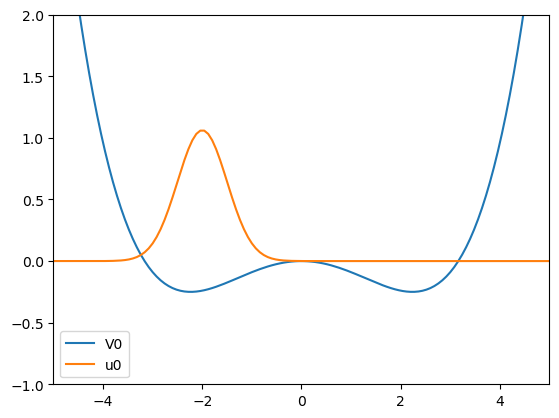

In [4]:
x0 = -2.0
sigma = 0.5
u0 = exp(-(x-x0)**2/(2*sigma**2))
u0 = ex.normalize(u0, xrange)   # normalize also makes it complex

V0 = x**4 - 10*x**2

ex.plot(plt, x, V0/100)
ex.plot(plt, x, real(u0))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V0','u0'])
plt.show()

### Brute force solution using `matrix_exp` when $e=0$ (i.e. no laser)

First we create the Hamiltonian matrix: 

$$ \mathbf{H}_0 = -\mathrm{D}_2 + \texttt{diag}(V_0). $$

In [5]:
D2 = ex.diffmatrix(2, N, xrange)
H0 = -D2 + es.linalg.diag(V0)

Now we can compute the matrix exponential $\exp\left(-i t \mathbf{H}\right)$ using `torch`s `matrix_exp` function and compute the solution as

$$ u(t) = \exp\left(-i t \mathbf{H}\right) u(0). $$

In [6]:
T = 1.0
uT = es.linalg.matmul(matrix_exp(-1j*T*H0), u0)

Let's plot the solution at $T=1$:

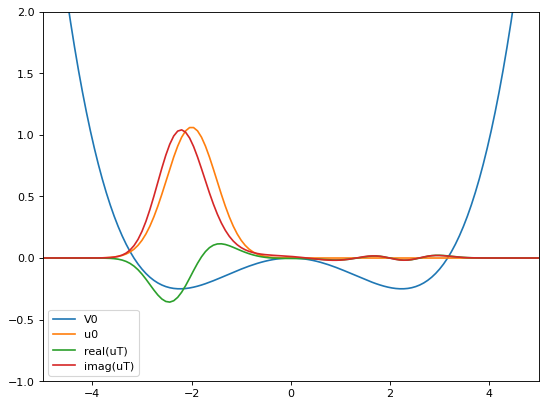

In [7]:
plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, V0/100)
ex.plot(plt, x, real(u0),':k')
ex.plot(plt, x, real(uT))
ex.plot(plt, x, imag(uT))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V0','u0','real(uT)','imag(uT)'])
plt.show()

The true solution of the Schrödinger equation conserves many properties. A exw of them are:

$$ \|u(t)\|_{L^2} = \|u(0)\|_{L^2}$$

$$ \langle u(t) , \mathrm{H} u(t) \rangle = \langle u(0) , \mathrm{H} u(0) \rangle$$

i.e. 

* The $L^2$ norm of the solution is conserved (and is $=1$ if we start with normalised initial condition). This property is crucial since the amplitude $|u(x,t)|^2$ defines a probability density function and must integrate to $1$ (i.e. overall probability of finding a particle somewhere should be $1$).

* The energy (i.e. $\langle u(t) , \mathrm{H} u(t) \rangle$) is conserved.

Let's see if our numerical solution using `expm` conserves these quantities:

In [8]:
print(f'L2 norm of initial condition was {ex.l2norm(u0, xrange)}')
print(f'L2 norm of expm solution at T is {ex.l2norm(uT, xrange)}')
print(f'Change in L2 norm is {ex.l2norm(uT, xrange) - ex.l2norm(u0, xrange)}')

L2 norm of initial condition was tensor([1.], dtype=torch.float64)
L2 norm of expm solution at T is tensor([1.0000], dtype=torch.float64)
Change in L2 norm is tensor([-3.0942e-12], dtype=torch.float64)


In [9]:
E0 = real(ex.l2inner(u0, es.linalg.matmul(H0, u0)))
ET = real(ex.l2inner(uT, es.linalg.matmul(H0, uT)))

print(f'Energy of initial condition was {E0}')
print(f'Energy of expm solution at T is {ET}')
print(f'Change in Energy is {ET-E0}')

Energy of initial condition was tensor([-2.0203], dtype=torch.float64)
Energy of expm solution at T is tensor([-2.0203], dtype=torch.float64)
Change in Energy is tensor([1.2540e-11], dtype=torch.float64)


We see that the numerical solution obtained with `matrix_exp` conserves the $L^2$ norm and energy up to machine precision.

### Observables

The inner product

$$ \mathbb{E}_u[O] := \langle O \rangle_u := \langle u, O u \rangle $$

defines the expected value of the *observable* $O$ when the state of the quantum system is given by the wavefunction $u$. An observable is a Hermitian matrix (or operator) and the expected value of the observable is always real. 

The energy we computed above is the expected value of the Hamiltonian $\mathrm{H}$, and the $L^2$ norm is the expected value of the identity observable $O=I$. 

Some other observables of interest are:

* $O=x$. This gives us the position of the particle.
* $O=-i \partial_x$. This gives us the momentum of the particle.
* $O=-\partial_x^2$. This gives us the kinectic energy of the particle.
* $O=V(x)$. This gives us the potential energy of the particle.

All these quantities are the expected or mean values.

Observables are implemented using the `observable` function, the syntax of which is:

```Python
    ex.observable(O, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `O` is a Hermitian operator or matrix. Let us see this with examples where we create named observables as `lambda` functions:

In [10]:
D1 = ex.diffmatrix(1, N, xrange)

energy = lambda f: ex.observable(H0, f, xrange)
position = lambda f: ex.observable(es.linalg.diag(x), f, xrange)
momentum = lambda f: ex.observable(1j*D1, f, xrange)
kinetic = lambda f: ex.observable(D2, f, xrange)
potential = lambda f: ex.observable(es.linalg.diag(V0), f, xrange)

In [11]:
print(f'Energy changes from {energy(u0)} to {energy(uT)}')
print(f'Mean position changes from {position(u0)} to {position(uT)}')
print(f'Momentum changes from {momentum(u0)} to {momentum(uT)}')
print(f'Kinectic energy changes from {kinetic(u0)} to {kinetic(uT)}')
print(f'Potential energy changes from {potential(u0)} to {potential(uT)}')

Energy changes from tensor([-20.2031], dtype=torch.float64) to tensor([-20.2031], dtype=torch.float64)
Mean position changes from tensor([-2.0000], dtype=torch.float64) to tensor([-2.1985], dtype=torch.float64)
Momentum changes from tensor([5.6205e-16], dtype=torch.float64) to tensor([0.5491], dtype=torch.float64)
Kinectic energy changes from tensor([-2.0000], dtype=torch.float64) to tensor([-2.4721], dtype=torch.float64)
Potential energy changes from tensor([-22.2031], dtype=torch.float64) to tensor([-22.6752], dtype=torch.float64)


Note that even though total energy is conserved, Kinectic and Potential energy are not conserved (no differrent from the case of a pendulum, of course). 

Momentum is nearly 0, but becomes 0.55 at $T=1$.

### Overlaps

In [12]:
xTarget = 2.0
sigma = 0.5
uTarget = exp(-(x-xTarget)**2/(2*sigma**2))
uTarget = ex.normalize(uTarget, xrange)     # normalize also makes it complex

overlap = lambda f: abs(ex.l2inner(f, uTarget))**2

print(f'Overlap with Gaussian centred at x=2.0 changes from {overlap(u0)} to {overlap(uT)}')

Overlap with Gaussian centred at x=2.0 changes from tensor([1.2664e-16], dtype=torch.float64) to tensor([1.8046e-08], dtype=torch.float64)


## Inefficient solution when there is laser

The second order Magnus expansion leads to the method

$$ u_{n+1} = \exp\left(i h \mathrm{D}_2 -i h\, \texttt{diag}(V_0) - i r_n \texttt{diag}(x)\right) u_n $$

where we approximate the integral in $r_n$ as

$$ r_n \approx \frac{h}{2}(e(t_n)+e(t_{n+1})) $$

We can compute the exponential using `matrix_exp`. This is highly inefficient. 

In [13]:
H0 = -D2 + es.linalg.diag(V0)

e = lambda t: -100 * sin(5*pi*t)

u = u0
for n in range(M):
    r = (h/2)*(e(t[n-1]) + e(t[n]))
    MagnusO2 = -1j*h*H0 - 1j*r*es.linalg.diag(x)
    u = es.linalg.matmul(matrix_exp(MagnusO2), u)

uTlaser = u

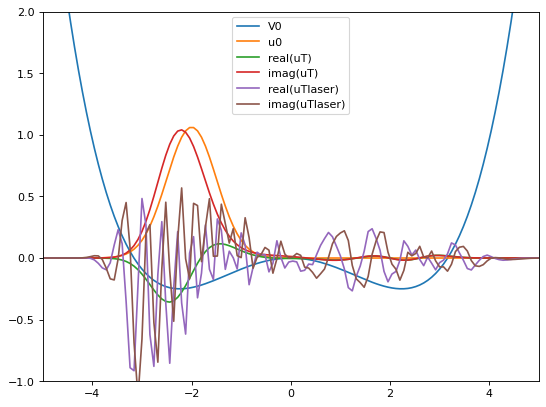

In [14]:
plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, V0/100)
ex.plot(plt, x, real(u0),':k')
ex.plot(plt, x, real(uT))
ex.plot(plt, x, imag(uT))
ex.plot(plt, x, real(uTlaser))
ex.plot(plt, x, imag(uTlaser))
plt.xlim(-5,5)
plt.ylim(-1,2)
plt.legend(['V0','u0','real(uT)','imag(uT)','real(uTlaser)','imag(uTlaser)'])
plt.show()

A more efficient solution is given by Strang splitting of the Magnus expansion,

$$ u_{n+1} = \exp\left(- \frac{i}{2}\, \texttt{diag}(W) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- \frac{i}{2}\, \texttt{diag}(W) \right) u_n $$

where $W:=h\, V + r_n x$

In [15]:
eLu = lambda h, u: ex.diffopexp(0, 2, 1j*h, u, xrange)
eWu = lambda W, u: exp(-1j*W)*u
strang = lambda h, W, u: eWu(W/2.0, eLu(h, eWu(W/2.0, u)))

def runstrang(T, M, u0, V0, e):
    u = u0
    h = T/M
    for n in range(M):
        r = (h/2)*(e(t[n-1]) + e(t[n]))
        W = h*V0 + r*x
        u = strang(h, W, u)
    return u

In [16]:
uTlaserStrang = runstrang(T, M, u0, V0, e)

Error due to Strang splitting

In [17]:
ex.l2norm(uTlaser-uTlaserStrang, xrange)

tensor([0.0004], dtype=torch.float64)

### Observables

In [18]:
print(f'Energy changes from {energy(u0)} to {energy(uTlaser)} ({energy(uT)} under no laser)')
print(f'Mean position changes from {position(u0)} to {position(uTlaser)} ({position(uT)} under no laser)')
print(f'Momentum changes from {momentum(u0)} to {momentum(uTlaser)} ({momentum(uT)} under no laser)')
print(f'Kinectic energy changes from {kinetic(u0)} to {kinetic(uTlaser)} ({kinetic(uT)} under no laser)')
print(f'Potential energy changes from {potential(u0)} to {potential(uTlaser)} ({potential(uT)} under no laser)')
print(f'Overlap with Gaussian centred at x=2.0 changes from {overlap(u0)} to {overlap(uTlaser)} ({overlap(uT)} under no laser)')

Energy changes from tensor([-20.2031], dtype=torch.float64) to tensor([196.8980], dtype=torch.float64) (tensor([-20.2031], dtype=torch.float64) under no laser)
Mean position changes from tensor([-2.0000], dtype=torch.float64) to tensor([-2.2126], dtype=torch.float64) (tensor([-2.1985], dtype=torch.float64) under no laser)
Momentum changes from tensor([5.6205e-16], dtype=torch.float64) to tensor([-11.9230], dtype=torch.float64) (tensor([0.5491], dtype=torch.float64) under no laser)
Kinectic energy changes from tensor([-2.0000], dtype=torch.float64) to tensor([-208.3045], dtype=torch.float64) (tensor([-2.4721], dtype=torch.float64) under no laser)
Potential energy changes from tensor([-22.2031], dtype=torch.float64) to tensor([-11.4065], dtype=torch.float64) (tensor([-22.6752], dtype=torch.float64) under no laser)
Overlap with Gaussian centred at x=2.0 changes from tensor([1.2664e-16], dtype=torch.float64) to tensor([8.8312e-09], dtype=torch.float64) (tensor([1.8046e-08], dtype=torch.flo

### Observables again

Recall that observables are implemented using the `observable` function, the syntax of which is:

```Python
    ex.observable(obs, u, xrange)
```
where `u` is the vector of values on a periodic grid defined on the domain `xrange`, and `obs` is a Hermitian operator or matrix. In the first instance, we used `obs` as Hermitian matrices. However, this is not fully efficient. For example passing the $n \times n$ Hamiltonian matrix will involve a cost of $\mathcal{O}\left(n^2\right)$ in the computation of the observable. Instead, if we use the operator form, the cost is $\mathcal{O}\left(n \log n\right)$ due to the use of FFTs. Let's see this with examples:

We can also create the observables as lambda functions. 

In [19]:
obs = {'energy': lambda psi: -ex.diffop(0, 2, psi, xrange) + V0*psi, 
'position': lambda psi: x*psi,
'momentum': lambda psi: 1j*ex.diffop(0, 1, psi, xrange),
'kinetic': lambda psi: -ex.diffop(0, 2, psi, xrange),
'potential':lambda psi: V0*psi,
'overlap':lambda psi: ex.l2inner(uTarget, psi, xrange)*psi}

We will store the values of observables in the dictionary `obsvalues`. Let us set all values to `[]`

In [20]:
obsvalues = {}
for o in obs:
    obsvalues[o]=[]

def compute_obs_values(u):
    for o in obs:
        op = obs[o]
        obsvalues[o].append(ex.observable(op, u, xrange).flatten())

Redefine runstrang to store observables as well

In [21]:
def runstrang(T, M, u0, V0, e):
    u = u0
    h = T/M
    for n in range(M):
        r = (h/2)*(e(t[n-1]) + e(t[n]))
        W = h*V0 + r*x
        u = strang(h, W, u)
        compute_obs_values(u)
    return u

In [22]:
compute_obs_values(u0)
uTlaserstrang_again = runstrang(T, M, u0, V0, e)

In [27]:
time_grid = es.timegrid([0,T], M)

Total energy does change now! Strang does not conserve energy exactly.

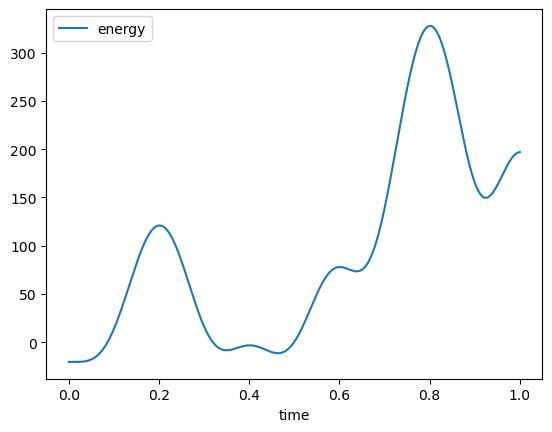

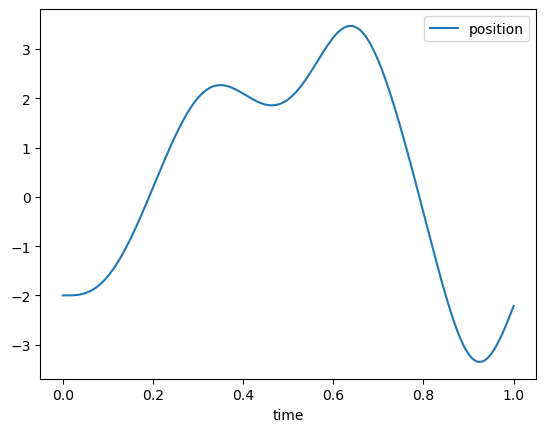

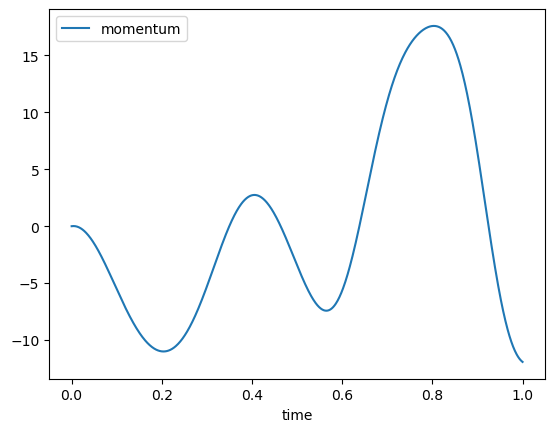

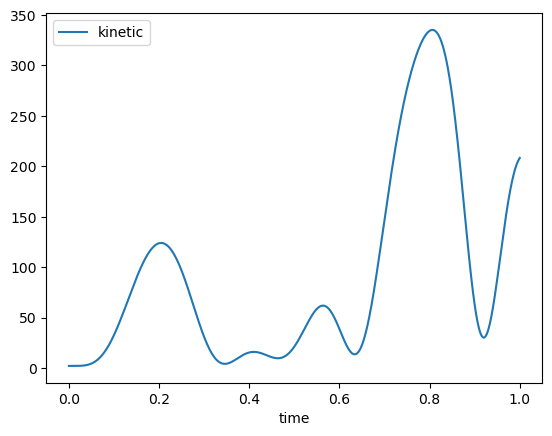

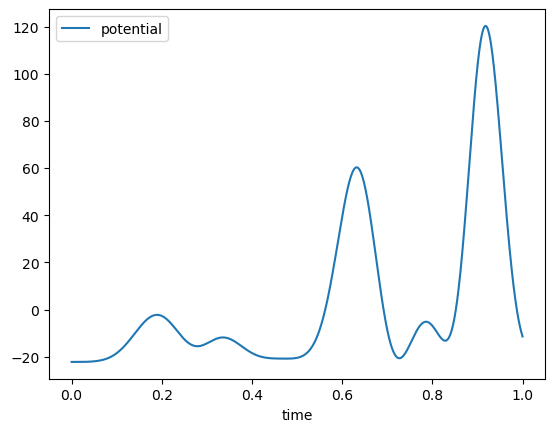

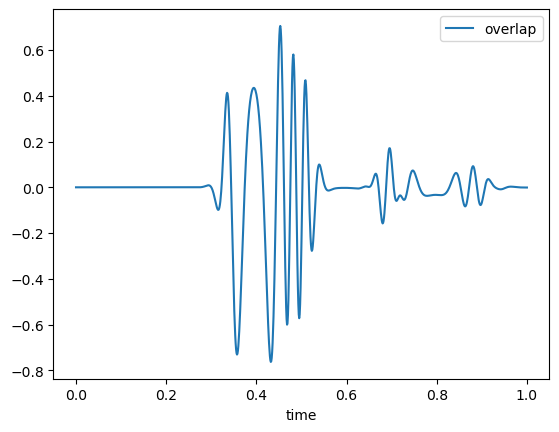

In [28]:
for o in obs:
    ov = obsvalues[o]
    plt.figure()
    plt.plot(time_grid, ov)   
    plt.legend([o])
    plt.xlabel('time')
    plt.show()
    